# Linear And Cyclical Workflows Using Functions And States

Using the functions and objects in `autora`, we can build flexible pipelines and cycles.

## Experiment Runner And Theorist

We define a two part AER pipeline consisting of an experiment runner and a theorist (we use the seed conditions
always).

The key part here is that both experiment runner and theorist are functions which:
- operate on the `State`, and
- return a modified object of the **same type** `State`.

### Defining The State

We use the standard State object bundled with `autora`: `StandardState`


In [ ]:
import numpy as np
import pandas as pd
from autora.variable import VariableCollection, Variable
from autora.state.bundled import StandardState

s = StandardState(
    variables=VariableCollection(independent_variables=[Variable("x", value_range=(-15,15))],
                                 dependent_variables=[Variable("y")]),
    conditions=pd.DataFrame({"x": np.linspace(-15,15,101)}),
    experiment_data = pd.DataFrame(columns=["x","y"]),
)

In [ ]:
s

StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(-15, 15), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=        x
0   -15.0
1   -14.7
2   -14.4
3   -14.1
4   -13.8
..    ...
96   13.8
97   14.1
98   14.4
99   14.7
100  15.0

[101 rows x 1 columns], experiment_data=Empty DataFrame
Columns: [x, y]
Index: [], models=[])

Given this state, we define a two part AER pipeline consisting of an experiment runner and a theorist. We'll just
reuse the initial seed `conditions` in this example.

First we define and test the experiment runner.

The key part here is that both the experiment runner and the theorist are functions which operate on the `State`.
We use the wrapper function `wrap_to_use_state` that wraps the experiment_runner and makes it operate on the
fields of the `State` rather than the `conditions` and `experiment_data` directly.

### Defining The Experiment Runner

For this example, we'll use a polynomial of degree 3 as our "ground truth" function. We're also using pandas
DataFrames and Series as our data interchange format.

In [ ]:
from autora.state.delta import wrap_to_use_state, Delta

def ground_truth(x: pd.Series, c=(432, -144, -3, 1)):
    return c[0] + c[1] * x + c[2] * x**2 + c[3] * x**3

@wrap_to_use_state
def experiment_runner(conditions, std=100., random_state=None):
    """Coefs from https://www.maa.org/sites/default/files/0025570x28304.di021116.02p0130a.pdf"""
    rng = np.random.default_rng(random_state)
    x = conditions["x"]
    noise = rng.normal(0, std, len(x))
    y = (ground_truth(x) + noise)
    experiment_data = conditions.assign(y = y)
    return Delta(experiment_data=experiment_data)

When we run the experiment runner, we can see the updated state object which is returned – it has new experimental data.

In [ ]:
experiment_runner(s, std=1).experiment_data

,x,y
0,-15.0,-1458.277776
1,-14.7,-1275.239274
2,-14.4,-1102.572539
3,-14.1,-935.381331
4,-13.8,-780.490659
...,...,...
96,13.8,500.506401
97,14.1,609.386647
98,14.4,721.981947
99,14.7,843.750465


### Defining The Theorist

Now we define a theorist, which does a linear regression on the polynomial of degree 5. We define a regressor and a
method to return its feature names and coefficients, and then the theorist to handle it. Here, we use a different wrapper `theorist_from_estimator` that wraps the regressor and returns a function with the same functionality, but operating on `State` fields. In this case, we want to use the `State` field `experiment_data` and extend the `State` field `models`.

In [ ]:
from sklearn.linear_model import LinearRegression
from autora.state.wrapper import theorist_from_estimator
from sklearn.pipeline import make_pipeline as make_theorist_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Completely standard scikit-learn pipeline regressor
regressor = make_theorist_pipeline(PolynomialFeatures(degree=5), LinearRegression())
theorist = theorist_from_estimator(regressor)

def get_equation(r):
    t = r.named_steps['polynomialfeatures'].get_feature_names_out()
    c = r.named_steps['linearregression'].coef_
    return pd.DataFrame({"t": t, "coefficient": c.reshape(t.shape)})


### Directly Chaining State Based Functions

Now we run the theorist on the result of the experiment runner (by chaining the two functions).

In [ ]:
t = theorist(experiment_runner(s, random_state=1))

The fitted coefficients are:

In [ ]:
get_equation(t.model)

,t,coefficient
0,1,0.000000
1,x,-145.723526
2,x^2,-2.909293
3,x^3,1.048788
4,x^4,-0.000242
5,x^5,-0.000252


### Creating A Pipeline With State Based Functions

Now we can define the simplest pipeline which runs the experiment runner and theorist in sequence and returns the
updated state:

In [ ]:
def pipeline(state: StandardState, random_state=None) -> StandardState:
    s_ = state
    t_ = experiment_runner(s_, random_state=random_state)
    u_ = theorist(t_)
    return u_

Running this pipeline is the same as running the individual steps – just pass the state object.

In [ ]:
u = pipeline(s, random_state=1)
get_equation(u.model)

,t,coefficient
0,1,0.000000
1,x,-145.723526
2,x^2,-2.909293
3,x^3,1.048788
4,x^4,-0.000242
5,x^5,-0.000252


Since the pipeline function operates on the `State` itself and returns a `State`, we can chain these pipelines in the same fashion as we chain the theorist and experiment runner:

In [ ]:
u_ = pipeline(pipeline(s, random_state=1), random_state=2)
get_equation(u_.model)

,t,coefficient
0,1,0.000000
1,x,-145.738569
2,x^2,-2.898667
3,x^3,1.042038
4,x^4,-0.000893
5,x^5,-0.000218


To show what's happening, we'll show the data, best fit model and ground truth:

,t,coefficient
0,1,0.000000
1,x,-145.738569
2,x^2,-2.898667
3,x^3,1.042038
4,x^4,-0.000893
5,x^5,-0.000218


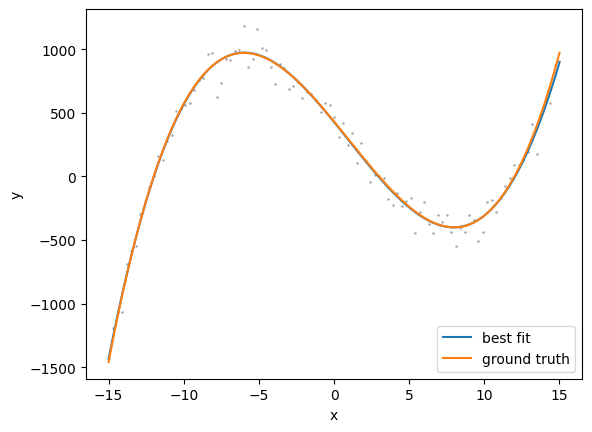

In [ ]:
from matplotlib import pyplot as plt


def show_best_fit(state):
    state.experiment_data.plot.scatter("x", "y", s=1, alpha=0.5, c="gray")

    observed_x = state.experiment_data[["x"]].sort_values(by="x")
    observed_x = pd.DataFrame({"x": np.linspace(observed_x["x"].min(), observed_x["x"].max(), 101)})

    plt.plot(observed_x, state.model.predict(observed_x), label="best fit")
    
    allowed_x = pd.Series(np.linspace(*state.variables.independent_variables[0].value_range, 101), name="x")
    plt.plot(allowed_x, ground_truth(allowed_x), label="ground truth")
    
    plt.legend()

def show_coefficients(state):
    return get_equation(state.model)

show_best_fit(u)
show_coefficients(u)

We can use this pipeline to make a trivial cycle, where we keep on gathering data until we reach 1000 datapoints. Any
 condition defined on the state object could be used here, though.

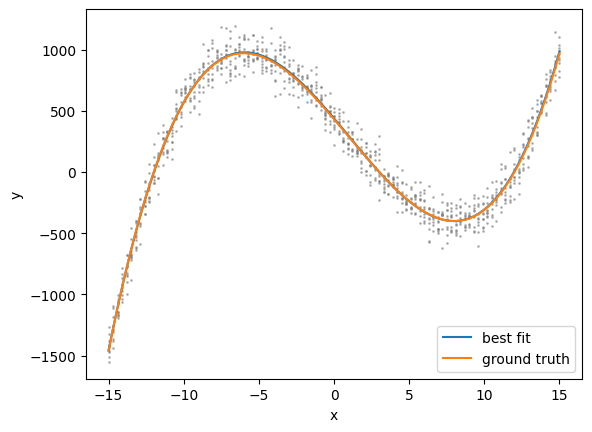

In [ ]:
v = s
while len(v.experiment_data) < 1_000:  # any condition on the state can be used here.
    v = pipeline(v)
show_best_fit(v)

### Creating Generators With State Based Functions

We can redefine the pipeline as a generator, which can be operated on using iteration tools:

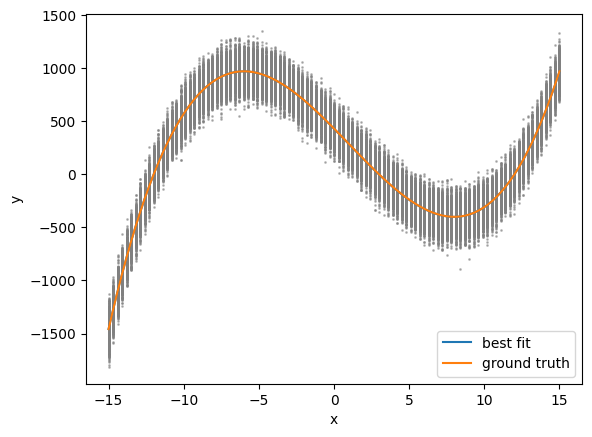

In [ ]:
def cycle(state: StandardState) -> StandardState:
    s_ = state
    while True:
        s_ = experiment_runner(s_)
        s_ = theorist(s_)
        yield s_

cycle_generator = cycle(s)

for i in range(1000):
    t = next(cycle_generator)
show_best_fit(t)

You can also define a cycle (or a sequence of steps) which yield the intermediate results.

In [ ]:
v0 = s
def cycle(state: StandardState) -> StandardState:
    s_ = state
    while True:
        print("#-- running experiment_runner --#\n")
        s_ = experiment_runner(s_)
        yield s_
        print("#-- running theorist --#\n")
        s_ = theorist(s_)
        yield s_

cycle_generator = cycle(v0)

At the outset, we have no model and an emtpy `experiment_data` dataframe.

In [ ]:
print(f"{v0.model=}, \n{v0.experiment_data=}")

v0.model=None, 
v0.experiment_data=Empty DataFrame
Columns: [x, y]
Index: []


In the first `next`, we only run the "experiment_runner"

In [ ]:
v1 = next(cycle_generator)
print(f"{v1.model=}, \n{v1.experiment_data=}")

#-- running experiment_runner --#

v1.model=None, 
v1.experiment_data=        x            y
0   -15.0 -1545.935365
1   -14.7 -1144.076706
2   -14.4 -1146.527730
3   -14.1 -1100.649495
4   -13.8  -746.834562
..    ...          ...
96   13.8   521.681151
97   14.1   674.091679
98   14.4   770.699562
99   14.7   848.473161
100  15.0   953.358913

[101 rows x 2 columns]


In the next step, we run the theorist on that data, but we don't add any new data:

In [ ]:
v2 = next(cycle_generator)
print(f"{v2.model=}, \n{v2.experiment_data.shape=}")

#-- running theorist --#

v2.model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())]), 
v2.experiment_data.shape=(101, 2)


In the next step, we run the experiment runner again and gather more observations:

In [ ]:
v3 = next(cycle_generator)
print(f"{v3.model=}, \n{v3.experiment_data.shape=}")


#-- running experiment_runner --#

v3.model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())]), 
v3.experiment_data.shape=(202, 2)


## Adding The Experimentalist

Modifying the code to use a custom experimentalist is simple. We define an experimentalist which adds four observations each cycle:


In [ ]:
from autora.experimentalist.random_ import random_pool

experimentalist = random_pool
experimentalist(s)

StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(-15, 15), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=           x
0   0.787469
1 -11.056959
2 -12.028324
3   0.278927
4   7.568485, experiment_data=Empty DataFrame
Columns: [x, y]
Index: [], models=[])

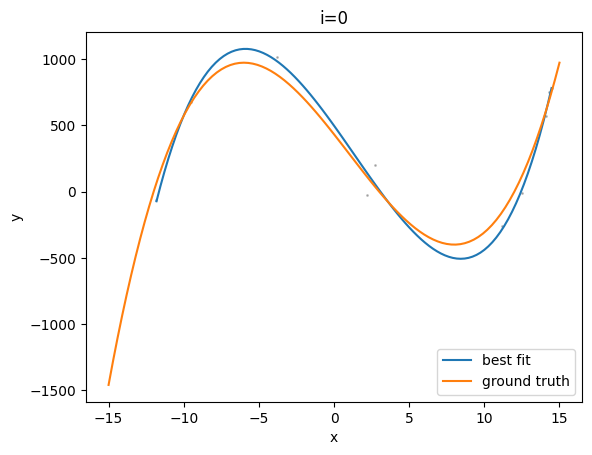

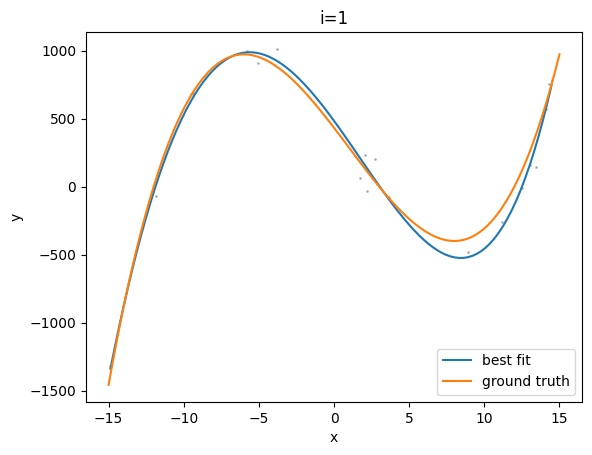

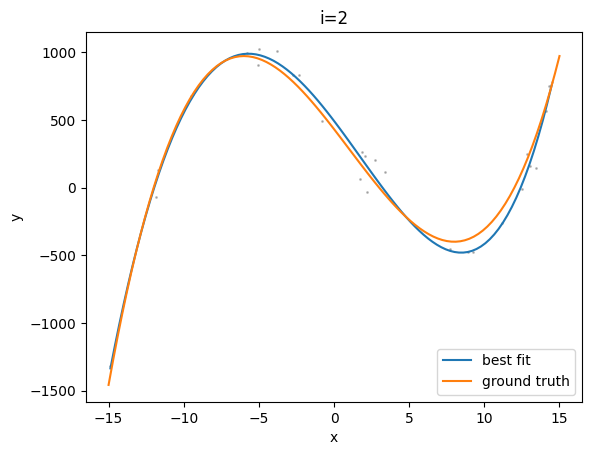

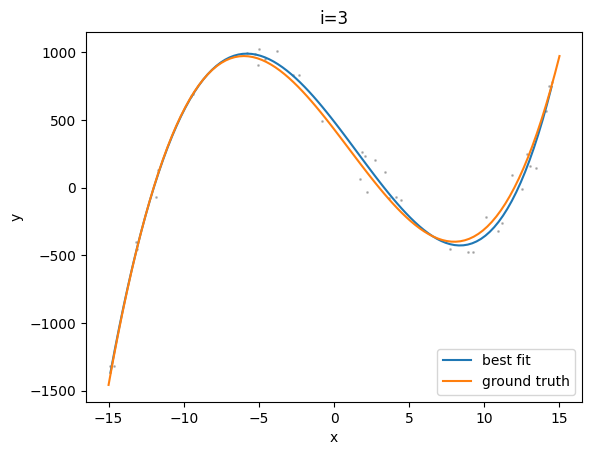

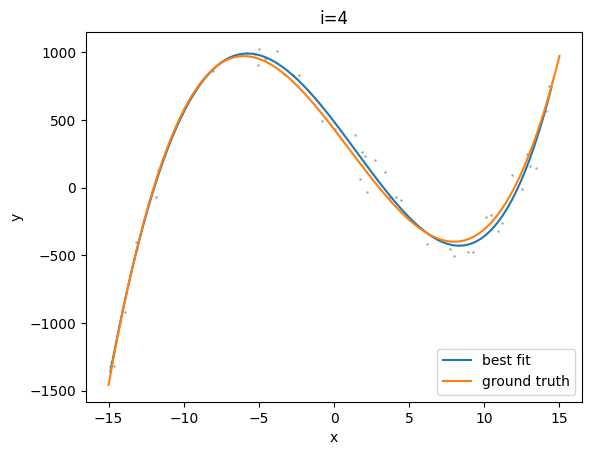

In [ ]:
u0 = s
for i in range(5):
    u0 = experimentalist(u0, num_samples=10)
    u0 = experiment_runner(u0)
    u0 = theorist(u0)
    show_best_fit(u0)
    plt.title(f"{i=}")